In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.signal import find_peaks
# import graph_class
import cv2
import skimage
import math
import copy
import time
import pyrealsense2 as rs

In [ ]:
class PIDController:
    def __init__(self, P=1.0, I=0.0, D=0.0):
        self.Kp = P
        self.Ki = I
        self.Kd = D
        self.prev_error = 0.0
        self.integral = 0.0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        return output

In [23]:
def ipm_ll(image):
    # for single lane

    x1, y1 = 202, 480
    x2, y2 = 265, 360
    x3, y3 = 360, 360
    x4, y4 = 470, 480

    u1, v1 = x1, y1
    u2, v2 = 202, 0
    u3, v3 = 470, 0
    u4, v4 = x4, y4


    # for all road
    # x1, y1 = 0, 480
    # x2, y2 = 150, 360
    # x3, y3 = 480, 360
    # x4, y4 = 640, 480

    # u1, v1 = x1, y1
    # u2, v2 = 0, 0
    # u3, v3 = 640, 0
    # u4, v4 = x4, y4
    
    image = np.asanyarray(image, dtype=np.uint8)
    image = cv2.resize(image, dsize=(640, 480))
    
    # camera points
    points_camera = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32)

    # birds-eye view points
    points_birdseye = np.array([[u1+200, v1+200], [u2+200, v2+200], [u3+200, v3+200], [u4+200, v4+200]], dtype=np.float32)

    homography_matrix, _ = cv2.findHomography(points_camera, points_birdseye)

    transformed_image = cv2.warpPerspective(image, homography_matrix, (640+200+200, 480+200)) # cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    return transformed_image, homography_matrix


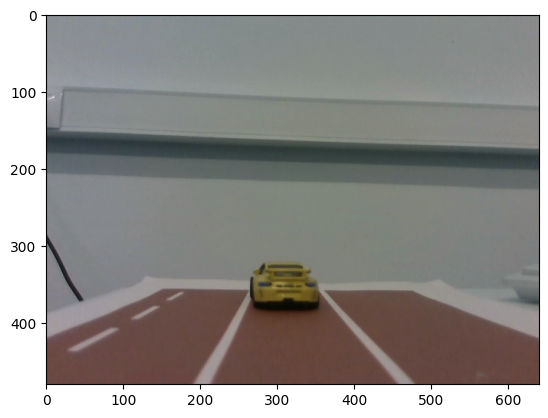

In [3]:
img = cv2.imread('rs_color_img2.jpg')
imshow(img)

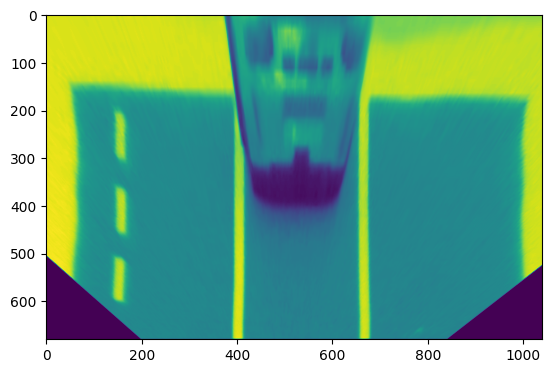

In [4]:
gs_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tr_img, H = ipm_ll(gs_img)
imshow(tr_img)

In [ ]:
# need to calculate w - width of car 
# cm
h = 15 # height of camera 
d = get_dist() # to center of bbox
L = get_dist() # to center of horizontal line from bottom bbox line
l = math.sqrt(d ** 2 - h ** 2) # from ground to center of bbox
c = math.sqrt(L ** 2 - h ** 2) # from ground to center line
alpha = math.acos(c / l) # between bbox and vertial line

In [60]:
pipe = rs.pipeline()
cnfg  = rs.config()

cnfg.enable_stream(rs.stream.color, 640,480, rs.format.bgr8, 30)
cnfg.enable_stream(rs.stream.depth, 640,480, rs.format.z16, 30)

profile = pipe.start(cnfg)
# align depth to rgb
align = rs.align(rs.stream.color)
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
print(depth_scale)
while True:
    frames = pipe.wait_for_frames()

    aligned_frames = align.process(frames)
    depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    # depth_frame = frame.get_depth_frame()
    # color_frame = frame.get_color_frame()

    if not color_frame or not depth_frame: # ???
        continue

    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())

    # dist = depth_frame.get_distance(int(x),int(y))


    depth_cm = cv2.applyColorMap(cv2.convertScaleAbs(depth_image,
                                    alpha = 0.5), cv2.COLORMAP_JET)
    
    cv2.imshow('depth', color_image)
    
    if cv2.waitKey(1) == ord('q'):
        break

pipe.stop()
cv2.destroyAllWindows() 


0.0010000000474974513


In [57]:
depth_image[0, 200] * depth_scale

0.8960000425577164

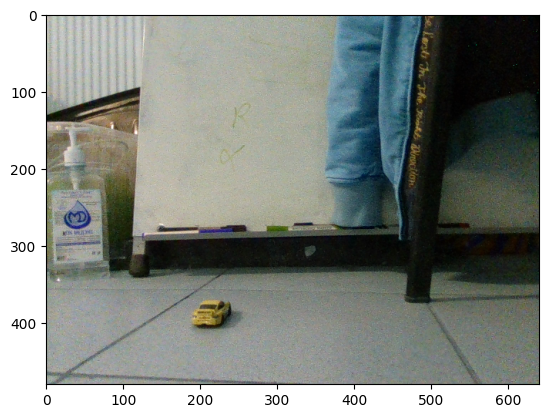

In [61]:
imshow(color_image)

In [9]:
cv2.imwrite('new_depth.jpg', depth_image)

True

In [2]:
graph = graph_class.Graph()

In [3]:
a = np.array([[0,0,1,0],
              [1,1,2,1],
              [2,2,3,2]])

b = np.array([[0,-1,1,-1],
              [1,0,2,0],
              [2,1,3,1]])

In [4]:
def get_dist(p1, p2):
    p2[0] = p2[0] + abs(p2[2] - p2[0]) // 2
    p2 = p2[:2]
    return np.linalg.norm(
        np.array(p1) - np.array(p2)
    )

In [5]:
xc, yc = 0, -3
for vert1 in b:
    # graph.add_vert(tuple(vert1))
    for vert2 in a:
        # graph.add_vert(vert2)
        l1 = get_dist((xc, yc), copy.copy(vert1))
        l2 = get_dist((xc, yc), copy.copy(vert2))
        graph.add_edge4(tuple(vert1), tuple(vert2), l1, l2)

In [6]:
graph

{(0, -1, 1, -1): [((2, 2, 3, 2), 3.605551275463989),
  ((0, 0, 1, 0), 1.0),
  ((1, 1, 2, 1), 2.23606797749979)],
 (1, 0, 2, 0): [((0, 0, 1, 0), 1.0),
  ((1, 1, 2, 1), 1.0),
  ((2, 2, 3, 2), 2.23606797749979)],
 (2, 1, 3, 1): [((0, 0, 1, 0), 2.23606797749979),
  ((1, 1, 2, 1), 1.0),
  ((2, 2, 3, 2), 1.0)]}

In [8]:
vertices = list(graph.keys())
new_graph = graph_class.Graph()

for i in range(len(vertices)):
    neighbours = graph[vertices[i]] 
    min_cost, ind  = min(((item[1], index) for index, item in enumerate(neighbours)), key=lambda x: x[0])
    l1 = get_dist((xc, yc), list(copy.copy(vertices[i])))
    l2 = get_dist((xc, yc), list(copy.copy(neighbours[ind][0])))
    new_graph.add_edge4(tuple(vertices[i]), tuple(neighbours[ind][0]), l1, l2)

In [9]:
new_graph

{(0, -1, 1, -1): [((0, 0, 1, 0), 1.0)],
 (1, 0, 2, 0): [((0, 0, 1, 0), 1.0)],
 (2, 1, 3, 1): [((1, 1, 2, 1), 1.0)]}

In [11]:
new_graph[(0, -1, 1, -1)][0][1]

1.0

In [10]:
list(new_graph.keys())

[(0, -1, 1, -1), (1, 0, 2, 0), (2, 1, 3, 1)]

In [12]:
vertices = list(new_graph.keys())
dt = 2
vel_graph = copy.copy(new_graph)
for vert in vertices:
    dl =  vel_graph[vert][0][1] # add if not use depth: config.step *
    vel_graph[vert] += [dl / dt] # m/s

In [13]:
vel_graph

{(0, -1, 1, -1): [((0, 0, 1, 0), 1.0), 0.5],
 (1, 0, 2, 0): [((0, 0, 1, 0), 1.0), 0.5],
 (2, 1, 3, 1): [((1, 1, 2, 1), 1.0), 0.5]}

In [32]:
expanded_map = np.zeros((10,5))

In [33]:
vertices = list(vel_graph.keys())
k = 2
for vert in vertices:
    w = abs(vert[0] - vert[2])
    y = int(vert[1] - k * w)
    # expanded_map[y:vert[1], vert[0]:vert[2]] = 255
    dl =  vel_graph[vert][1] * 2
    expanded_map[int(y-dl)+5:vert[1]+5, vert[0]:vert[2]] = 255

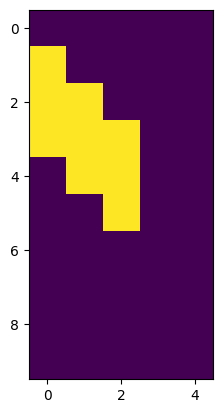

In [34]:
imshow(expanded_map)

________________________________

In [6]:
def find_nearest(graph):
    vertices = list(graph.keys())
    new_graph = graph_class.Graph()
    
    for i in range(len(vertices)):
        neighbours = graph[vertices[i]] 
        # min_cost = min([x[1] for x in graph[neighbours[i]]])
        min_cost, ind  = min(((item[1], index) for index, item in enumerate(neighbours)), key=lambda x: x[0])
        # graph.remove_edge(neighbours[i], )
        new_graph.add_edge(vertices[i], neighbours[ind][0])
        
    return new_graph

In [19]:
ng = find_nearest(graph)
ng

{(0, -1): [((0, 0), 1.0)], (1, 0): [((1, 1), 1.0)], (2, 1): [((2, 2), 1.0)]}

In [23]:
vertices = list(graph.keys())
vel_graph = copy.copy(ng)
for vert in vertices:
    dl = vel_graph[vert][0][1]
    vel_graph[vert] += [dl/2]

In [24]:
vel_graph

{(0, -1): [((0, 0), 1.0), 0.5],
 (1, 0): [((1, 1), 1.0), 0.5],
 (2, 1): [((2, 2), 1.0), 0.5]}

In [ ]:
ng.get_weight()

In [5]:
def ipm_ll(image):
    # for single lane

    # x1, y1 = 290, 480
    # x2, y2 = 300, 380
    # x3, y3 = 360, 380
    # x4, y4 = 370, 480

    # u1, v1 = x1, y1
    # u2, v2 = 275, 0
    # u3, v3 = 370, 0
    # u4, v4 = x4, y4

    x1, y1 = 210, 480
    x2, y2 = 300, 315
    x3, y3 = 400, 315
    x4, y4 = 590, 480

    u1, v1 = x1, y1
    u2, v2 = 210, 0
    u3, v3 = 500, 0
    u4, v4 = x4, y4
    
    image = np.asanyarray(image, dtype=np.uint8)
    image = cv2.resize(image, dsize=(640, 480))
    
    # camera points
    points_camera = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32)

    # birds-eye view points
    points_birdseye = np.array([[u1+200, v1+200], [u2+200, v2+200], [u3+200, v3+200], [u4+200, v4+200]], dtype=np.float32)

    homography_matrix, _ = cv2.findHomography(points_camera, points_birdseye)

    transformed_image = cv2.warpPerspective(image, homography_matrix, (640+200+200, 480+200)) # cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    return transformed_image, homography_matrix


In [13]:
tr_img, h = ipm_ll(cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY))

In [62]:
tr_img2, h = ipm_ll(depth_image)

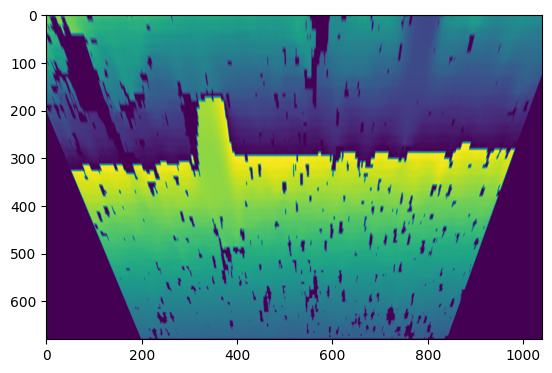

In [63]:
imshow(tr_img2)

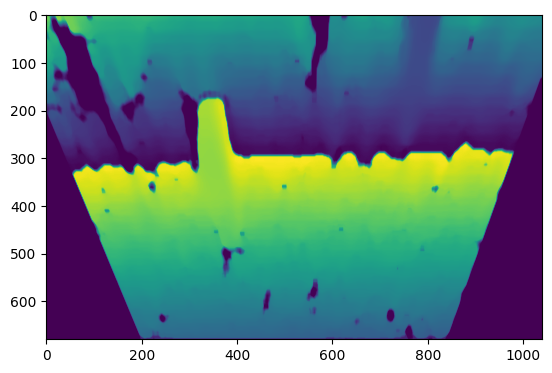

In [64]:
imshow(cv2.medianBlur(tr_img2, 17))

In [65]:
tr_img_new = cv2.medianBlur(tr_img2, 17)

In [73]:
tr_img_new[-10, 390] * depth_scale

0.08600000408478081

In [70]:
tr_img_new[460, 390] * depth_scale

0.19000000902451575

In [74]:
depth_image[-10, 190] * depth_scale

0.35000001662410796

In [59]:
cv2.medianBlur(depth_image.astype(np.uint8), 11)[0, 200] * depth_scale

0.12800000607967377

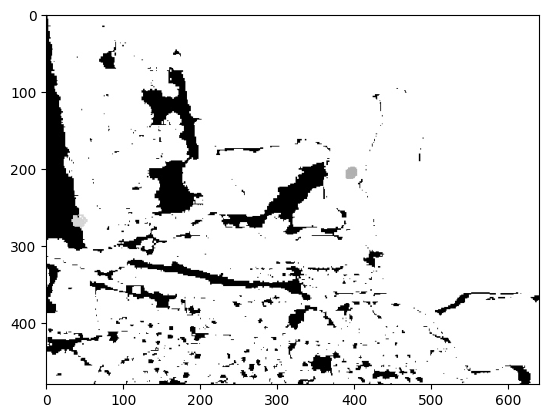

In [14]:
img_d = cv2.imread('for_hw_depth.jpg')
img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2GRAY)
imshow(img_d, cmap='gray')

In [38]:
point = [350, 400]
# distance = img_d[point[1]-15:point[1], point[0]-20:point[0]+20] # x, y
distance = img_d[point[1], point[0]] * 0.0010000000474974513
# distance,_,_,_ = cv2.mean(distance)

In [24]:
def get_distance(img_d, point):
    return img_d[point[1], point[0]] * 0.0010000000474974513

In [44]:
horizontal_line_center = (640 // 2 - 10, point[1]) # (x, y)
h = 0.13 # height of camera 
d = get_distance(img_d, point) # to center of bbox
L = get_distance(img_d, horizontal_line_center) # to center of horizontal line from bottom bbox line
l = math.sqrt(d ** 2 - h ** 2) # from ground to center of bbox
c = math.sqrt(L ** 2 - h ** 2) # from ground to center line
alpha = math.degrees(math.acos(c / l)) # between bbox and vertial line

In [46]:
l, alpha

(0.2193741237635918, 0.0)

In [50]:
l1, l2 = 6.325, 3.606
phi1, phi2 = math.radians(60), math.radians(45)
x1 = l1 * math.cos(math.pi - phi1)
y1 = l1 * math.sin(math.pi - phi1)
x2 = l2 * math.cos(math.pi - phi2)
y2 = l2 * math.sin(math.pi - phi2)
delta = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [2]:
img = cv2.imread('report_raw_lanes.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

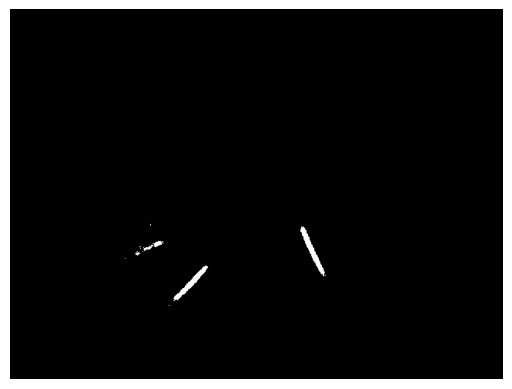

In [3]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_axis_off()

In [6]:
tr_img, _ = ipm_ll(img)

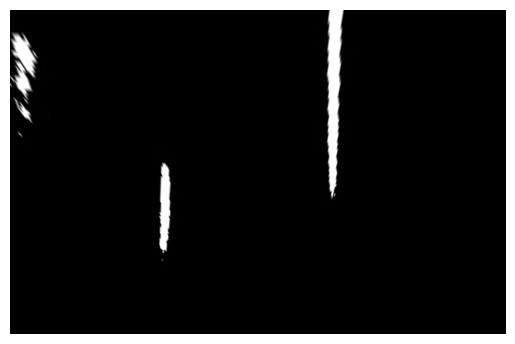

In [7]:
fig, ax = plt.subplots()
ax.set_axis_off()
imshow(tr_img, cmap='gray')

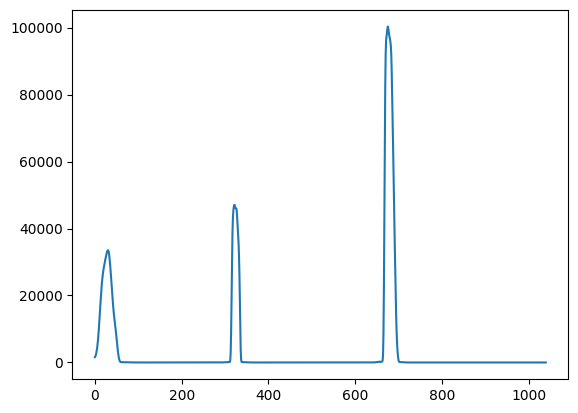

In [8]:

histogram = np.sum(tr_img, axis=0)
plt.plot(histogram)


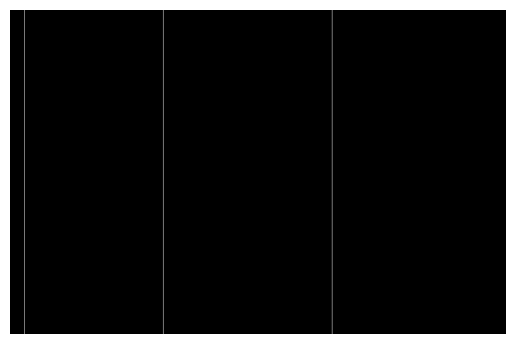

In [9]:
peaks, _ = find_peaks(histogram,  height=5000)  # prominence=10000, prominence - min height above surrounding
lanes_map = np.zeros_like(tr_img)
peaks = np.sort(peaks)

if len(peaks): # else ??????????????????????????????
    for peak in peaks:
        lanes_map[:, peak] = 255

fig, ax = plt.subplots()
ax.set_axis_off()
imshow(lanes_map, cmap='gray')

In [12]:
img2 = cv2.imread('report_extended.jpg')

In [13]:
img2[:,:,2] = 0

In [14]:
img2[:,:,1] = 0

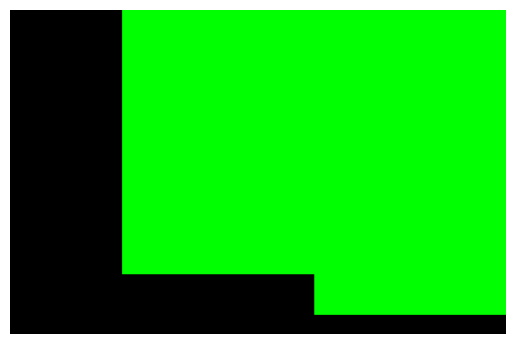

In [10]:
fig, ax = plt.subplots()
ax.set_axis_off()
imshow(img2)

In [15]:
cv2.imwrite('report_color_expand.jpg', img2)

True

In [2]:
a = np.ones((4,4))
b = np.zeros((4,4))

In [17]:
a[0, :] = 3
b[0, :] = 4
a[-1, :] = 5
b[-1, :] = 6
a[0, 0] = 7
b[0, 0] = 8
a, b

(array([[7., 3., 3., 3.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [5., 5., 5., 5.]]),
 array([[8., 4., 4., 4.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [6., 6., 6., 6.]]))

In [15]:
def merge_frames(frame_front, frame_back):
    frame_back = frame_back[::-1] # vertical mirror
    frame_back = frame_back[:, ::-1] # horizontal mirror
    merged_frame = np.concatenate((frame_front, frame_back), axis=0)
    return merged_frame

In [18]:
merge_frames(a,b)

array([[7., 3., 3., 3.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [5., 5., 5., 5.],
       [6., 6., 6., 6.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [4., 4., 4., 8.]])